# Загрузка Pandas и очистка данных

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
from collections import Counter
import re



RANDOM_SEED = 42

!pip freeze > requirements.txt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.rcParams['figure.figsize'] = (10,7)

In [2]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')

In [3]:
# Updating df_train
main_task_upd = pd.read_csv('main_task_update.csv')
main_task_upd = main_task_upd[['nr_reviews', 'excellent', 'v_good', 'average', 'poor', 'terrible']]
df_train = df_train.merge(main_task_upd, left_index=True, right_index = True)

# Updating df_test
kaggle_task_upd = pd.read_csv('kaggle_task_update.csv')
kaggle_task_upd = kaggle_task_upd[['nr_reviews', 'excellent', 'v_good', 'average', 'poor', 'terrible']]
df_test = df_test.merge(main_task_upd, left_index=True, right_index = True)

In [4]:
# Объединяем
df_train['sample'] = 1
df_test['sample'] = 0
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [5]:
# World city dataset
cities = pd.read_csv('worldcities.csv')
## Загружаем и чистим
cities = cities.drop(['city', 'lat', 'lng', 'iso2', 'iso3', 'admin_name', 'id'], axis=1)
cities.columns = ['City', 'Country', 'Capital', 'Population']
cities = cities.drop_duplicates(subset=['City'], keep='first')
## Приведем название города Porto в соответствие с основным датасетом => Oporto
## https://en.wikipedia.org/wiki/Porto
cities['City'] = cities['City'].apply(lambda x: 'Oporto' if x == 'Porto' else x)
### Добавляем к основному датасету
data = data.merge(cities, on = 'City', how = 'left')


# Top-100 tourist cities of the world dataset
tourism_top100 = pd.read_excel('wpTop100Cities19.xlsx', header=None, skiprows=2)
## Добавляем к основному датасету
## 1 если входит в топ-100 туристических городов (по данным за 2017-2019 года), 0 если нет
data['tourism_top100'] = data['City'].apply(lambda x: 1 if x in list(tourism_top100[1]) else 0)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   nr_reviews         50000 non-null  int64  
 10  excellent          50000 non-null  int64  
 11  v_good             50000 non-null  int64  
 12  average            50000 non-null  int64  
 13  poor               50000 non-null  int64  
 14  terrible           50000 non-null  int64  
 15  sample             50000 non-null  int64  
 16  Rating             500

In [7]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # Restaurant_id
    
    ## Есть повторяющиеся id ресторанов. Однако их URL различны.
    ## Из этого сделаем предположение, что под id может подразумеваться сеть ресторанов.
    df_output['chain_size'] = df_output['Restaurant_id'].map(df_output['Restaurant_id'].value_counts().to_dict())
    
    ## Dummy: 0 если принадлежит к сети ресторанов, 1 если нет
    df_output['chain'] = df_output['chain_size'].apply(lambda x: 0 if x > 1 else 1)
    
    ## chain_size скоррелировал с ranking
    ## Создадим из двух один параметр
    df_output['ranking-chain_size'] = df_output['Ranking'] / df_output['chain_size']
    
    
    
    # City
    
    ## Заменим названия городов на Dummy
    df_output['city_id'] = df_output['City']
    le = LabelEncoder()
    le.fit(df_output['city_id'])
    df_output['city_id'] = le.transform(df_output['city_id'])
    
    df_city = pd.get_dummies(df_output['City'])
    df_output = df_output.merge(df_city, left_index=True, right_index = True)
    
    ## Подсчитаем количество ресторанов для города
    df_output['restaurant_per_city'] = df_output['City'].map(df_output.groupby(['City'])['Restaurant_id'].count().to_dict())
    ## Нормализуем значения
#     scaler=MinMaxScaler()
#     df_output['restaurant_per_city_norm'] = scaler.fit_transform(pd.DataFrame(df_output['restaurant_per_city']))
    
    
    
    # Capital (new data)
    
    ## Заполним пропуски
    ## Edinburgh - столица Шотландии
    df_output['Capital'] = df_output['Capital'].fillna('primary')
    
    ## Dummy: 0 если столица, 1 если нет
    df_output['Capital'] = df_output['Capital'].apply(lambda x: 0 if x=='primary' else 1)
    
    
    
    # Country (new data)
    
    ## Заменим названия стран на Dummy
    df_output['country_id'] = df_output['Country']
    le = LabelEncoder()
    le.fit(df_output['country_id'])
    df_output['country_id'] = le.transform(df_output['country_id'])
    
    df_output['Country'] = df_output['Country'].apply(lambda x: x + '_country')
    df_country = pd.get_dummies(df_output['Country'])
    df_output = df_output.merge(df_country, left_index=True, right_index = True)
    
    
    
    # Population (new data)
    
    ## Согласно описанию датасета "worldcities.csv" в "Population" используется муниципальное население
    ## Что, в целом, должно коррелировать с городским населением
    ### Нормализуем значения
    ### т.к. города повторяются, чтобы не вносить погрешность в среднее значение сгруппируем
    population = pd.DataFrame(df_output.groupby('City')['Population'].mean())
    scaler=StandardScaler()
    population['population_norm'] = scaler.fit_transform(population)
    population = population.drop('Population', axis=1)
    df_output = df_output.merge(population, on='City', how='left')
    
    df_output['Population'] = df_output['Population']/100000
    
    ## Подсчитаем "плотность" ресторанов в городе
    ## Т.е. подсчитаем количество ресторанов на душу населения в каждом городе
    df_output['restaurant_per_capita'] = df_output['restaurant_per_city']/data['Population']
    
    
    
    # Ranking
    
    ## Так как реальное количество ресторанов явно больше чем представлено в датасете,
    ## Посчитаем "относительное место", которое занимает ресторан среди "всех" ресторанов своего города
    df_output['relative_ranking'] = df_output['restaurant_per_city']/df_output['Ranking']
#     df_output['relative_ranking'] = df_output['Ranking']/df_output['restaurant_per_city']
    
    df_output['relative_ranking_per_capita'] = df_output['restaurant_per_city']/df_output['Population']
    
    ## Нормализуем значения
#     scaler=StandardScaler()
#     df_output['ranking_norm'] = scaler.fit_transform(pd.DataFrame(df_output['Ranking']))
    
    
    
    # Cuisine Style
    
    ## Заполним пропуски и очистим строки
    df_output['Cuisine Style'].fillna('National', inplace = True)
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: re.sub("[\]'\[]", '', x))
    
    ## Подсчитаем количество предлагаемых видов кухонь в ресторане
    ## Пропуск (other) считаем за один вид
    df_output['cuisines_count'] = df_output['Cuisine Style'].str.count(',')+1
    
    
    cuisines = pd.DataFrame(df_output['Cuisine Style'].str.split(', ', expand = False).explode().reset_index())
    
    cuisines['city'] = df_output['City'].copy()
    
    df_output['cuisines_per_city'] = df_output['City'].map(cuisines.groupby('city')['Cuisine Style'].nunique().to_dict())
    df_output['relative_cuisines_count'] = df_output['cuisines_count']/df_output['cuisines_per_city']
    
    ## Сократить количество вариантов Cuisine Style
    N = 30
    most_popular_cuisines = ['National']
    for i in range(0,N):
        most_popular_cuisines.append(Counter(cuisines['Cuisine Style']).most_common(N)[i][0])
    
    cuisines['Cuisine Style'] = cuisines['Cuisine Style'].apply(lambda x: 'National' if x not in most_popular_cuisines else x)
    
    ## Создадим Dummy
    for cuisine in list(cuisines['Cuisine Style'].unique()):
        id_list = list(cuisines[cuisines['Cuisine Style']==cuisine]['index'])
        df_output[cuisine] = pd.DataFrame(df_output.index.map(lambda x: 1 if x in id_list else 0))
   

    
    # Price Range
    
    price_dict = {'$':0, '$$ - $$$': 1, '$$$$': 2}
    df_output['Price Range'] = df_output['Price Range'].map(price_dict)
    
    ## Предположим, что цены в одной сети ресторанов +- одинаковые
    ## Заполним пропуски медианным значением для каждой сети ресторанов
    df_output['Price Range'].fillna(df_output['Restaurant_id'].\
                                    map(df_output.groupby(['Restaurant_id'])['Price Range'].median().to_dict()),\
                                    inplace=True)
    
    ## Оставшиеся пропуски заполним медианным значением по каждому городу
    df_output['Price Range'].fillna(df_output['City'].\
                                    map(df_output.groupby(['City'])['Price Range'].median().to_dict()),\
                                    inplace=True)
    
    ##
    df_output['relative_price'] = df_output['Price Range']/df_output['relative_ranking']
    
    
    
    # Reviews
    
    ## Заполним пропуски
    df_output['Reviews'].fillna('nothing', inplace = True)
    
    ## Вытащим даты публикации Reviews
    df_output['reviews_date'] = df_output['Reviews'].apply(lambda x: pd.to_datetime(re.findall('\d{2}/\d{2}/\d{4}', x)))
    df_output['last_review_date'] = df_output['reviews_date'].apply(lambda x: max(x) if len(x)!=0 else None)
    df_output['next2last_review_date'] = df_output['reviews_date'].apply(lambda x: min(x) if len(x)>1 else None)
    
    ## Посчитаем промежуток времени между Reviews
    df_output['reviews_date_delta'] = (df_output['last_review_date'] - df_output['next2last_review_date']).dt.days
    ### Заполним пропуски
    df_output['reviews_date_delta'].fillna(0, inplace = True)
    
    ## Посчитаем сколько времени прошло с момента написания последнего Review
    df_output['last_review_age'] = (datetime.strptime('2021/01/17', '%Y/%m/%d') - df_output['last_review_date']).dt.days
    ### Заполним пропуски
    df_output['last_review_age'].fillna(0, inplace = True)
    
    
    
    # Number of Reviews
    
    ## Создаем временный столбец. 1 если есть хоть один отзыв и 0 если нет ни одного
    df_output['no_reviews'] = df_output['last_review_date'].apply(lambda x: 1 if pd.isna(x) == False else 0)
    ## Заполняем пропуски
    df_output['Number of Reviews'].fillna(1, inplace=True)
    ## Исправляем ранее присвоению единицу на 0 если отзывов нет
    df_output['Number of Reviews'] = df_output['Number of Reviews'] * df_output['no_reviews']
    ##
    df_output = df_output.drop(['no_reviews'], axis=1)
    
    ##
    df_output['review_per_day'] = df_output['reviews_date_delta'].apply(lambda x: 1/x if x > 0 else x)
    
    ## Как часто в городе оставляют отзывы
    df_output['review_per_capita'] = df_output['Number of Reviews']/df_output['Population']
    
    # Ранг ресторана с учетом частоты отзывов в городе
    df_output['WRR'] =  df_output['relative_ranking']  *  df_output['review_per_capita']
    
    
    
    ##
#     df_output['cuisines_count-num_rev'] = pd.DataFrame(map(lambda x, y: x/y if y > 0 else 0,\
#                                                            df_output['cuisines_count'],\
#                                                            df_output['Number of Reviews']))
    
    ## Так как snapshot "старый" нормализует last_review_age
    scaler=MinMaxScaler()
#     scaler=StandardScaler()
    df_output['last_review_age_norm'] = scaler.fit_transform(pd.DataFrame(df_output['last_review_age']))
    
    ## посмотреть что получится
    scaler=MinMaxScaler()
#     scaler=StandardScaler()
    df_output['reviews_date_delta_norm'] = scaler.fit_transform(pd.DataFrame(df_output['reviews_date_delta']))
    
    ## опять же посмотреть что получится
    df_output['restaurant_age_onTA'] = pd.DataFrame(map(lambda x, y: x/y if y > 0 else 0,\
                                                        df_output['Number of Reviews'],\
                                                        df_output['review_per_day']))
    
    ## так же
    scaler=MinMaxScaler()
    # scaler=StandardScaler()
    df_output['restaurant_age_onTA_norm'] = scaler.fit_transform(pd.DataFrame(df_output['restaurant_age_onTA']))
    
    
    
    # Review distribution
    
    df_output['excellent_perc'] = pd.DataFrame(map(lambda x, y: x/y if y>0 else 0,\
                                                   df_output['excellent'], df_output['nr_reviews']))

    df_output['v_good_perc'] = pd.DataFrame(map(lambda x, y: x/y if y>0 else 0,\
                                                df_output['v_good'], df_output['nr_reviews']))

    df_output['average_perc'] = pd.DataFrame(map(lambda x, y: x/y if y>0 else 0,\
                                                 df_output['average'], df_output['nr_reviews']))

    df_output['poor_perc'] = pd.DataFrame(map(lambda x, y: x/y if y>0 else 0,\
                                              df_output['poor'], df_output['nr_reviews']))

    df_output['terrible_perc'] = pd.DataFrame(map(lambda x, y: x/y if y>0 else 0,\
                                                  df_output['terrible'], df_output['nr_reviews']))
    
    df_output['good_vs_bad'] = pd.DataFrame(map(lambda a,b,c,d: (a+b)/(c+d) if (c+d)>0 else 0,\
                                                df_output['excellent'],
                                                df_output['v_good'],
                                                df_output['poor'],
                                                df_output['terrible']))
    
    return df_output

In [8]:
df_preproc = preproc_data(data)
df_preproc.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,nr_reviews,excellent,v_good,average,poor,terrible,sample,Rating,Country,Capital,Population,tourism_top100,chain_size,chain,ranking-chain_size,city_id,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,restaurant_per_city,country_id,Austria_country,Belgium_country,Czechia_country,Denmark_country,Finland_country,France_country,Germany_country,Greece_country,Hungary_country,Ireland_country,Italy_country,Luxembourg_country,Netherlands_country,Norway_country,Poland_country,Portugal_country,Slovakia_country,Slovenia_country,Spain_country,Sweden_country,Switzerland_country,United Kingdom_country,population_norm,restaurant_per_capita,relative_ranking,relative_ranking_per_capita,cuisines_count,cuisines_per_city,relative_cuisines_count,Bar,Pub,European,National,Gluten Free Options,Vegetarian Friendly,Vegan Options,Italian,Mediterranean,Seafood,French,Cafe,Fast Food,Portuguese,Central European,Pizza,British,Spanish,Middle Eastern,Halal,Indian,Thai,American,Asian,Wine Bar,Japanese,Sushi,Chinese,International,German,relative_price,reviews_date,last_review_date,next2last_review_date,reviews_date_delta,last_review_age,review_per_day,review_per_capita,WRR,last_review_age_norm,reviews_date_delta_norm,restaurant_age_onTA,restaurant_age_onTA_norm,excellent_perc,v_good_perc,average_perc,poor_perc,terrible_perc,good_vs_bad
19309,id_6739,Paris,"French, American, Cafe, International",6740.0,1.0,0.0,"[[], []]",/Restaurant_Review-g187147-d12950559-Reviews-S...,d12950559,39,6,0,0,2,0,1,5.0,France_country,0,110.20000,1,2,0,3370.000000,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6108,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.490592,0.000554,0.906231,55.426497,4,100,0.040000,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1.103471,"DatetimeIndex([], dtype='datetime64[ns]', freq...",NaT,NaT,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.153846,0.000000,0.000000,0.051282,0.000000,3.0
43575,id_527,Oslo,American,528.0,1.0,2.0,"[['Great taste, great service and budget frie....",/Restaurant_Review-g190479-d12919216-Reviews-S...,d12919216,33,18,1,0,0,0,1,5.0,Norway_country,0,6.93494,0,9,0,58.666667,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,488,13,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.451689,0.000704,0.924242,70.368309,1,65,0.015385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.081967,"DatetimeIndex(['2018-01-07', '2017-09-22'], dt...",2018-01-07,2017-09-22,107.0,1106.0,0.009346,0.288395,0.266547,0.180867,0.032464,214.0,0.000192,0.545455,0.030303,0.000000,0.000000,0.000000,0.0
10062,id_3662,Barcelona,Spanish,3663.0,0.0,26.0,"[['Great.', 'Nice'], ['08/31/2016', '05/17/201...",/Restaurant_Review-g187497-d5587837-Reviews-Ch...,d5587837,26,2,0,1,1,1,1,4.0,Spain_country,1,45.88000,1,7,0,523.285714,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3395,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.035090,0.000740,0.926836,73.997384,1,87,0.011494,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,"DatetimeIndex(['2016-08-31', '2016-05-17'], dt...",2016-08-31,2016-05-17,106.0,1600.0,0.009434,0.566696,0.525234,0.261652,0.032160,2756.0,0.002469,0.076923,0.000000,0.038462,0.038462,0.038462,1.0


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [9]:
drop_list = ['Restaurant_id',
             'City',
             'Cuisine Style',
#              'Ranking',
             'Price Range',
#              'relative_price',
#              'Number of Reviews',
             'Reviews',
             'URL_TA',
             'ID_TA',
             'nr_reviews',
             'excellent',
             'v_good',
             'average',
             'poor',
             'terrible',
#              'sample',
             'Rating',
             'Country',
#              'Capital',
             'Population',
             'tourism_top100',
             'chain_size',
             'chain',
             'ranking-chain_size',
             'city_id',
             'restaurant_per_city',
             'country_id',
             'population_norm',
             'restaurant_per_capita',
#              'relative_ranking',
#              'relative_ranking_per_capita',
#              'ranking_norm',
             'cuisines_count',
             'cuisines_per_city',
#              'relative_cuisines_count',
             'reviews_date',
             'last_review_date',
             'next2last_review_date',
             'reviews_date_delta',
             'last_review_age',
             'review_per_day',
#              'review_per_capita',
#              'cuisines_count-num_rev',
             'last_review_age_norm',
             'reviews_date_delta_norm',
             'restaurant_age_onTA',
             'restaurant_age_onTA_norm',
             'excellent_perc',
             'v_good_perc',
             'average_perc',
             'poor_perc',
             'terrible_perc'
            ]

In [10]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values
X = train_data.drop(drop_list, axis=1)

In [11]:
cities_list = list(data['City'].unique())
country_list = list(data['Country'].unique())

for i in range(len(country_list)):
    country_list[i] = country_list[i]+'_country'

In [12]:
cuis = ['Bar',
        'Pub',
        'European',
        'National',
        'Gluten Free Options',
        'Vegetarian Friendly',
        'Vegan Options',
        'Italian',
        'Mediterranean',
        'Seafood',
        'French',
        'Cafe',
        'Fast Food',
        'Portuguese',
        'Central European',
        'Pizza',
        'British',
        'Spanish',
        'Middle Eastern',
        'Halal',
        'Indian',
        'Thai',
        'American',
        'Asian',
        'Wine Bar',
        'Japanese',
        'Sushi',
        'Chinese',
        'International',
        'German'
       ]

In [13]:
corr_list = drop_list+cuis+cities_list+country_list
corr_list.append('sample')

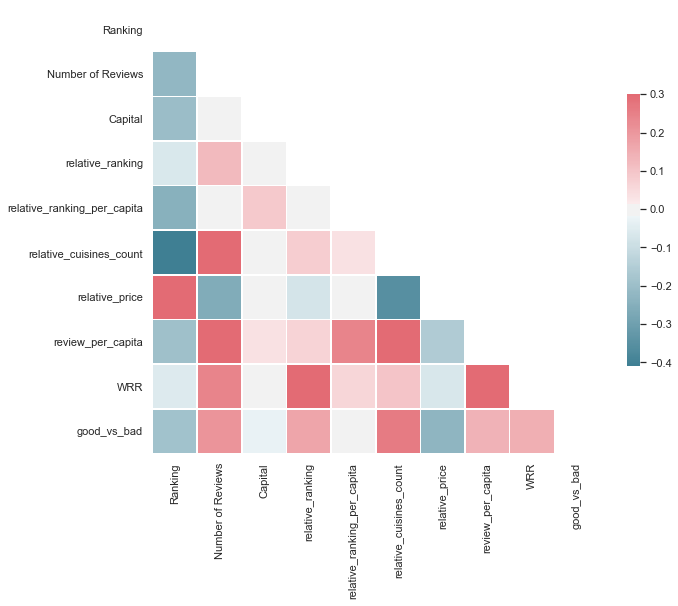

In [14]:
# drop_list.append('sample')
sns.set(style="white")
corr = df_preproc.drop(corr_list, axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [15]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём, обучаем и тестируем модель

In [16]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [17]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [18]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20643562499999996


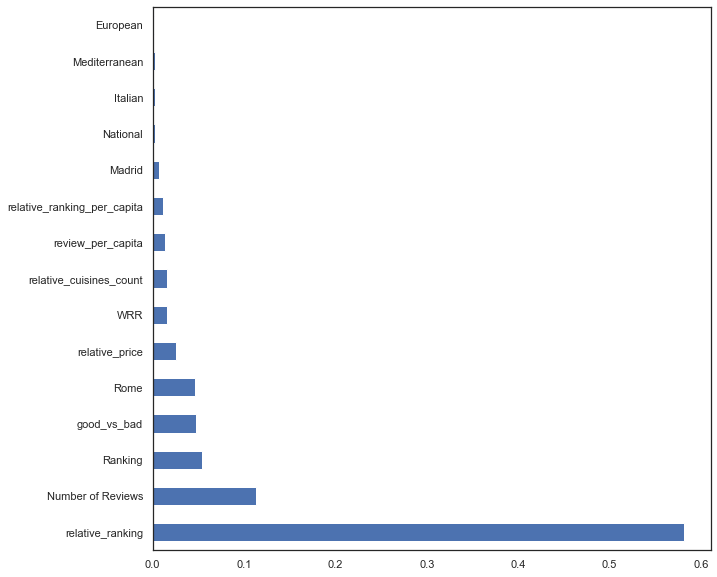

In [19]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Conclusion

1. Модель стала предсказывать Rating хуже Baseline модели
2. predict_submission выглядит очень усредненным, все значения в районе 3-4 баллов
   - Какой-то из добавленных параметров сильно усредняет значения
   - Предположительно таким параметром является Population
   - Возможно стоило подобрать более релевантный dataset
3. Или не стоило так сильно увлекаться добавлением новых параметров